In [1]:
import os
import re
import jax
device = 'cpu'
if device == 'cpu':
    platform = os.getenv("JAX_PLATFORM_NAME", "cpu")
    jax.config.update("jax_platform_name", platform)
    Ncores = os.cpu_count()    
    xla_flags = os.getenv("XLA_FLAGS", "")
    xla_flags = re.sub(r"--xla_force_host_platform_device_count=\S+", "", xla_flags).split()
    os.environ["XLA_FLAGS"] = " ".join(["--xla_force_host_platform_device_count={}".format(Ncores)] + xla_flags)
    jax.config.update("jax_platform_name", platform)
    print('jax.local_device_count ',jax.local_device_count(backend=None))
elif device == 'gpu':
    platform = os.getenv("JAX_PLATFORM_NAME", "gpu")
    jax.config.update("jax_platform_name", platform)
elif device == 'tpu':
    platform = os.getenv("JAX_PLATFORM_NAME", "tpu")
    jax.config.update("jax_platform_name", platform)
else:
    print("platform not handled")


jax.local_device_count  16


In [2]:
import jax
import time as tm
import random as r
from jax import jit
from jax import random
import jax.numpy as jnp
from functools import partial
from tensorflow_probability.substrates import jax as tfp
import tensorflow_probability.substrates.jax.distributions as tfd
root = tfd.JointDistributionCoroutine.Root

# Simulate data

In [3]:
import math
import os

import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Image, set_matplotlib_formats
from matplotlib.patches import Ellipse, transforms

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import expit

import numpy as onp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS, Predictive

def sim_data(N_cafes = 20):
    a = 3.5  # average morning wait time
    b = -1  # average difference afternoon wait time
    sigma_a = 1  # std dev in intercepts
    sigma_b = 0.5  # std dev in slopes
    rho = -0.7  # correlation between intercepts and slopes
    Mu = jnp.array([a, b])
    cov_ab = sigma_a * sigma_b * rho
    Sigma = jnp.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])

    sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
    Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix

    # now matrix multiply to get covariance matrix
    Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

    seed = random.PRNGKey(5)  # used to replicate example
    vary_effects = dist.MultivariateNormal(Mu, Sigma).sample(seed, (N_cafes,))
    a_cafe = vary_effects[:, 0]
    b_cafe = vary_effects[:, 1]
    seed = random.PRNGKey(22)
    N_visits = 10
    afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
    cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
    mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
    sigma = 0.5  # std dev within cafes
    wait = dist.Normal(mu, sigma).sample(seed)
    d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

    return d

c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TFB

## Jit functions for random factors

In [4]:
init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
init_key = jnp.array(init_key)


@partial(jit, static_argnums=(1, 2,))
def vec_to_mat(arr, N, K):
    return jnp.reshape(arr, (N, K))

@jit
def jax_LinearOperatorDiag(s, cov):    
    def multiply_with_s(a):
        return jnp.multiply(a, s)
    vectorized_multiply = vmap(multiply_with_s)
    return jnp.transpose(vectorized_multiply(cov))
import jax.numpy as jnp

@jit
def diag_pre_multiply(v, m):
    return jnp.matmul(jnp.diag(v), m)
@jit
def random_centered(sigma, cor_mat, offset_mat):
    """Generate the centered matrix of random factors 

    Args:
        sigma (vector): Prior, vector of length N
        cor_mat (2D array): correlation matrix, cholesky_factor_corr of dim N, N
        offset_mat (2D array): matrix of offsets, matrix of dim N*k

    Returns:
        _type_: 2D array
    """
    return jnp.dot(diag_pre_multiply(sigma, cor_mat), offset_mat)



## Sampler

In [5]:
import tensorflow_probability
def NUTStrans(model,  obs,  n_chains = 1, init = None, bijectors = None, target_log_prob_fn = None,
         num_results = 500,
         num_burnin_steps=500,
         num_steps_between_results=0,
         parallel_iterations = 10,
         seed=0):

    init_key, key = random.split(random.PRNGKey(int(seed)))
    init_key = jnp.array(init_key)

    tensor = tfd.JointDistributionCoroutine(model)
    init_params = tensor.sample(seed = init_key)
    
    bijectors = [
        tfp.bijectors.Exp(),
        tfp.bijectors.Identity(),
        tfp.bijectors.Identity(),
        tfp.bijectors.Exp(),
        tfp.bijectors.CorrelationCholesky(),
        tfp.bijectors.Identity(),
    ]
    init_params = list(init_params)[:-1]

    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
        )
    
    if target_log_prob_fn == None:
        def target_log_prob(*params):
            return tensor.log_prob(params + (obs,))
    else:
        def target_log_prob(*params):
            return target_log_prob_fn(params + (obs,))
    @jit
    def run_chain(key):
        inner_kernel = tfp.mcmc.NoUTurnSampler(
            target_log_prob,
            step_size= 1e-3
        )

        kernel = tensorflow_probability.substrates.jax.mcmc.TransformedTransitionKernel(
                inner_kernel=inner_kernel,
                bijector=bijectors
        )
        
        hmc  = tfp.mcmc.DualAveragingStepSizeAdaptation(
            kernel,
            target_accept_prob=.8,
            num_adaptation_steps=int(0.8*500),
            step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
                  inner_results=pkr.inner_results._replace(step_size=new_step_size)
              ),
            step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
        )
        
        return tfp.mcmc.sample_chain(num_results = num_results,
                                     num_steps_between_results = num_steps_between_results,
                                     current_state= init_params,
                                     kernel=hmc,
                                     trace_fn=trace_fn,
                                     num_burnin_steps=num_burnin_steps,
                                     parallel_iterations = parallel_iterations,
                                     seed=key)
    

    start = tm.time()  
    rng_keys = jax.random.split(random.PRNGKey(0), n_chains)
    result =  jax.pmap(run_chain)(rng_keys)
    end = tm.time()    
    print(f"HonnorMode took: {end - start:.4f} seconds")
    posterior, sample_stats = result

    return posterior, sample_stats 

## Model 20 N_cafes

In [ ]:
d = sim_data(20)
cafe_id = jnp.array(d.cafe.values)
afternoon = jnp.array(d.afternoon.values)
N_cafes = 20
def model():    
    sigma = yield root(tfd.Sample(tfd.Exponential(1), sample_shape= 1))
    a = yield root(tfd.Sample(tfd.Normal(5, 2), sample_shape= 1))
    b = yield root(tfd.Sample(tfd.Normal(-1, 0.5), sample_shape= 1))
    sigma_cafe = yield root(tfd.Sample(tfd.Exponential(1), sample_shape= 2))   
    Rho = yield root(tfd.Sample(tfd.LKJ(2, 2), sample_shape= ()))
    a_cafe_b_cafe = yield root(tfd.Sample(tfd.MultivariateNormalTriL(loc = jnp.stack([a, b], axis=-1)[0], scale_tril =  Rho * sigma_cafe), sample_shape=N_cafes))
    mu = a_cafe_b_cafe[:, 0][cafe_id] + a_cafe_b_cafe[:, 1][cafe_id] * afternoon
    y = yield tfd.Independent(tfd.Normal(mu, sigma), reinterpreted_batch_ndims=[1])

start = tm.time()
posterior, sample_stats = NUTStrans(model, obs = jnp.array(d.wait.astype('float32').values))
end = tm.time()  
print(f"tfp took: {end - start:.4f} seconds")

c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

HonnorMode took: 7.8095 seconds
tfp took: 12.9435 seconds


## Model 200 N_cafes

In [ ]:
d = sim_data(200)
cafe_id = jnp.array(d.cafe.values)
afternoon = jnp.array(d.afternoon.values)
N_cafes = 200
def model():    
    sigma = yield root(tfd.Sample(tfd.Exponential(1)))
    a = yield root(tfd.Sample(tfd.Normal(5, 2)))
    b = yield root(tfd.Sample(tfd.Normal(-1, 0.5)))
    sigma_cafe = yield root(tfd.Sample(tfd.Exponential(1), sample_shape= 2))   
    Rho = yield root(tfd.Sample(tfd.LKJ(2, 2)))
    a_cafe_b_cafe = yield root(tfd.Sample(tfd.MultivariateNormalTriL(loc = jnp.stack([a, b], axis=-1)[0], scale_tril =  Rho * sigma_cafe), sample_shape=N_cafes))
    mu = a_cafe_b_cafe[:, 0][cafe_id] + a_cafe_b_cafe[:, 1][cafe_id] * afternoon
    y = yield tfd.Independent(tfd.Normal(mu, sigma), reinterpreted_batch_ndims=[1])

start = tm.time()
posterior, sample_stats = NUTStrans(model, obs = jnp.array(d.wait.astype('float32').values))
end = tm.time()  
print(f"tfp took: {end - start:.4f} seconds")

c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

HonnorMode took: 11.4997 seconds
tfp took: 13.5116 seconds


## Model 2000 N_cafes

In [ ]:
d = sim_data(2000)
cafe_id = jnp.array(d.cafe.values)
afternoon = jnp.array(d.afternoon.values)
N_cafes = 2000
def model():    
    sigma = yield root(tfd.Sample(tfd.Exponential(1)))
    a = yield root(tfd.Sample(tfd.Normal(5, 2)))
    b = yield root(tfd.Sample(tfd.Normal(-1, 0.5)))
    sigma_cafe = yield root(tfd.Sample(tfd.Exponential(1), sample_shape= 2))   
    Rho = yield root(tfd.Sample(tfd.LKJ(2, 2)))
    a_cafe_b_cafe = yield root(tfd.Sample(tfd.MultivariateNormalTriL(loc = jnp.stack([a, b], axis=-1)[0], scale_tril =  Rho * sigma_cafe), sample_shape=N_cafes))
    mu = a_cafe_b_cafe[:, 0][cafe_id] + a_cafe_b_cafe[:, 1][cafe_id] * afternoon
    y = yield tfd.Independent(tfd.Normal(mu, sigma), reinterpreted_batch_ndims=[1])

start = tm.time()
posterior, sample_stats = NUTStrans(model, obs = jnp.array(d.wait.astype('float32').values))
end = tm.time()  
print(f"tfp took: {end - start:.4f} seconds")

c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

HonnorMode took: 137.4494 seconds
tfp took: 139.4579 seconds


## Model 20000 N_cafes

In [8]:
d = sim_data(20000)
cafe_id = jnp.array(d.cafe.values)
afternoon = jnp.array(d.afternoon.values)
N_cafes = 20000
def model():    
    sigma = yield root(tfd.Sample(tfd.Exponential(1)))
    a = yield root(tfd.Sample(tfd.Normal(5, 2)))
    b = yield root(tfd.Sample(tfd.Normal(-1, 0.5)))
    sigma_cafe = yield root(tfd.Sample(tfd.Exponential(1), sample_shape= 2))   
    Rho = yield root(tfd.Sample(tfd.LKJ(2, 2)))
    a_cafe_b_cafe = yield root(tfd.Sample(tfd.MultivariateNormalTriL(loc = jnp.stack([a, b], axis=-1)[0], scale_tril =  Rho * sigma_cafe), sample_shape=N_cafes))
    mu = a_cafe_b_cafe[:, 0][cafe_id] + a_cafe_b_cafe[:, 1][cafe_id] * afternoon
    y = yield tfd.Independent(tfd.Normal(mu, sigma), reinterpreted_batch_ndims=[1])

start = tm.time()
posterior, sample_stats = NUTStrans(model, obs = jnp.array(d.wait.astype('float32').values))
end = tm.time()  
print(f"tfp took: {end - start:.4f} seconds")

c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  minval = minval + np.zeros([1] * final_rank, dtype=dtype)
c:\Users\SSosa\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\tensorflow_probability\python\internal\backend\jax\random_generators.py:284: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'>  is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jaxrand.randint(key=seed, s

HonnorMode took: 5179.2299 seconds
tfp took: 5184.1946 seconds
tfp took: 5184.1946 seconds


# Numpyro

## Model 20 N_cafes

In [ ]:
d = sim_data(20)
def model(cafe, afternoon, wait):
    a = numpyro.sample("a", dist.Normal(5, 2))
    b = numpyro.sample("b", dist.Normal(-1, 0.5))
    sigma_cafe = numpyro.sample("sigma_cafe", dist.Exponential(1).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    Rho = numpyro.sample("Rho", dist.LKJ(2, 2))
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = numpyro.sample(
        "a_cafe,b_cafe", dist.MultivariateNormal(jnp.stack([a, b]), cov).expand([20])
    )
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    numpyro.sample("wait", dist.Normal(mu, sigma), obs=wait)

start = tm.time()
m14_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m14_1.run(random.PRNGKey(0), d.cafe.values, d.afternoon.values, d.wait.values)
end = tm.time()
print(f"npr took: {end - start:.4f} seconds")
post_pr = m14_1.get_samples()

sample: 100%|██████████| 1000/1000 [00:05<00:00, 176.15it/s, 15 steps of size 2.70e-01. acc. prob=0.86]


npr took: 15.4913 seconds


## Model 200 N_cafes

In [ ]:
d = sim_data(200)
def model(cafe, afternoon, wait):
    a = numpyro.sample("a", dist.Normal(5, 2))
    b = numpyro.sample("b", dist.Normal(-1, 0.5))
    sigma_cafe = numpyro.sample("sigma_cafe", dist.Exponential(1).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    Rho = numpyro.sample("Rho", dist.LKJ(2, 2))
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = numpyro.sample(
        "a_cafe,b_cafe", dist.MultivariateNormal(jnp.stack([a, b]), cov).expand([200])
    )
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    numpyro.sample("wait", dist.Normal(mu, sigma), obs=wait)

start = tm.time()
m14_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m14_1.run(random.PRNGKey(0), d.cafe.values, d.afternoon.values, d.wait.values)
end = tm.time()
print(f"npr took: {end - start:.4f} seconds")

sample: 100%|██████████| 1000/1000 [00:07<00:00, 132.72it/s, 31 steps of size 2.21e-01. acc. prob=0.86]


npr took: 10.2059 seconds


## Model 2000 N_cafes

In [ ]:
d = sim_data(2000)
def model(cafe, afternoon, wait):
    a = numpyro.sample("a", dist.Normal(5, 2))
    b = numpyro.sample("b", dist.Normal(-1, 0.5))
    sigma_cafe = numpyro.sample("sigma_cafe", dist.Exponential(1).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    Rho = numpyro.sample("Rho", dist.LKJ(2, 2))
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = numpyro.sample(
        "a_cafe,b_cafe", dist.MultivariateNormal(jnp.stack([a, b]), cov).expand([2000])
    )
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    numpyro.sample("wait", dist.Normal(mu, sigma), obs=wait)

start = tm.time()
m14_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m14_1.run(random.PRNGKey(0), d.cafe.values, d.afternoon.values, d.wait.values)
end = tm.time()
print(f"npr took: {end - start:.4f} seconds")

sample: 100%|██████████| 1000/1000 [01:31<00:00, 10.88it/s, 127 steps of size 1.27e-01. acc. prob=0.84]


npr took: 94.6057 seconds


## Model 2000 N_cafes

In [7]:
d = sim_data(20000)
def model(cafe, afternoon, wait):
    a = numpyro.sample("a", dist.Normal(5, 2))
    b = numpyro.sample("b", dist.Normal(-1, 0.5))
    sigma_cafe = numpyro.sample("sigma_cafe", dist.Exponential(1).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    Rho = numpyro.sample("Rho", dist.LKJ(2, 2))
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = numpyro.sample(
        "a_cafe,b_cafe", dist.MultivariateNormal(jnp.stack([a, b]), cov).expand([20000])
    )
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    numpyro.sample("wait", dist.Normal(mu, sigma), obs=wait)

start = tm.time()
m14_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m14_1.run(random.PRNGKey(0), d.cafe.values, d.afternoon.values, d.wait.values)
end = tm.time()
print(f"npr took: {end - start:.4f} seconds")

sample: 100%|██████████| 1000/1000 [57:22<00:00,  3.44s/it, 1023 steps of size 7.12e-02. acc. prob=0.83] 


npr took: 3452.5231 seconds


# Posterior comparaison

In [9]:
post = m14_1.get_samples()

In [10]:
rNPR = [jnp.mean(post['sigma']), jnp.mean(post['a']), jnp.mean(post['b']), jnp.mean(post['sigma_cafe'], axis = 0),jnp.mean(post['Rho'], axis = 0), jnp.mean(post['a_cafe,b_cafe'], axis = 0)]

In [11]:
rTFB = [jnp.mean(posterior[0], axis = 1),jnp.mean(posterior[1], axis = 1),jnp.mean(posterior[2], axis = 1),jnp.mean(posterior[3], axis = 1),jnp.mean(posterior[4], axis = 1), jnp.mean(posterior[5], axis = 1)]

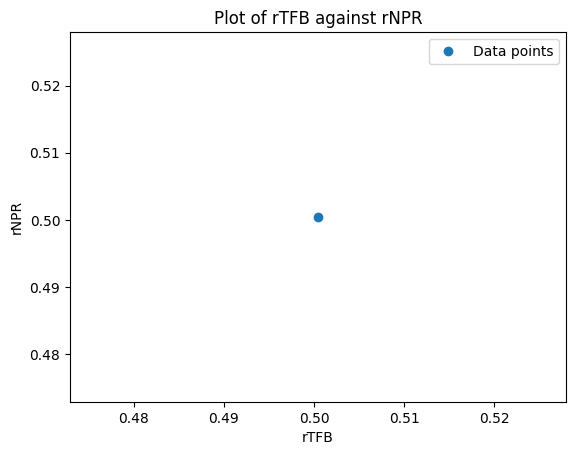

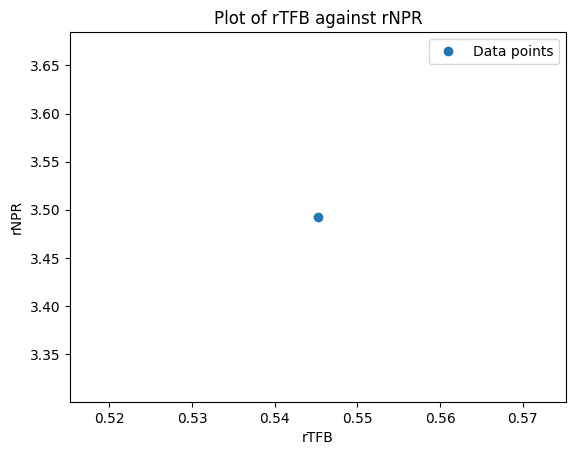

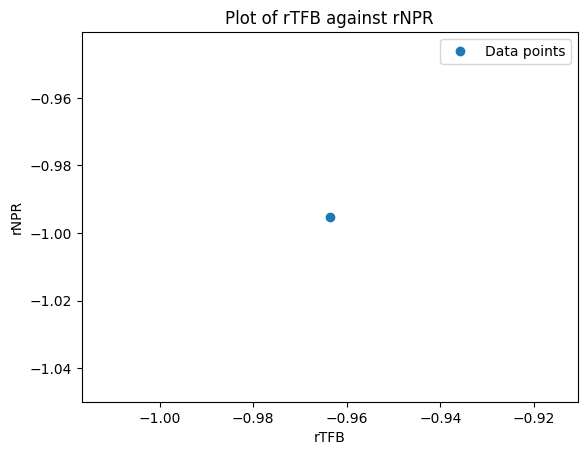

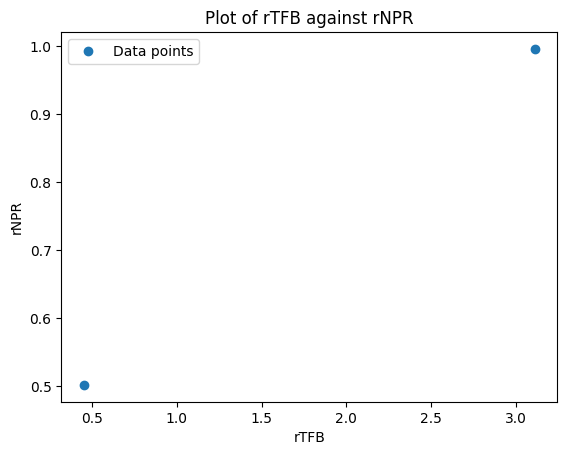

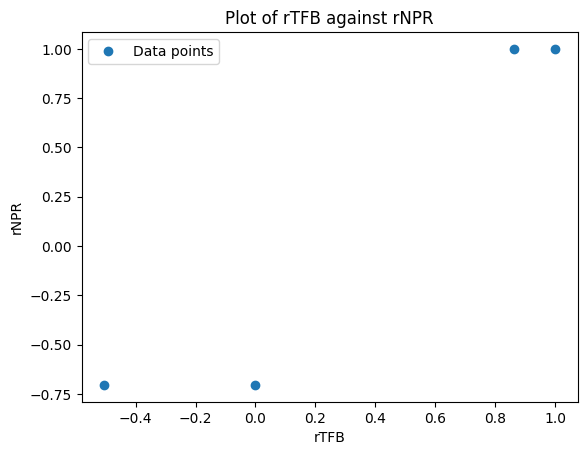

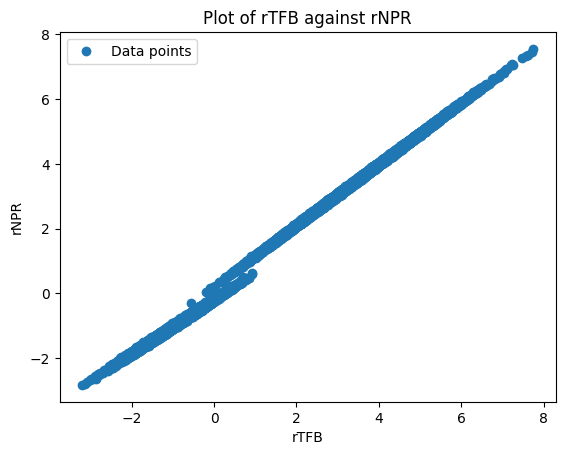

In [14]:
import matplotlib.pyplot as plt
def flatten_array(arr):
    if arr.ndim > 1:
        return arr.flatten()
    return arr

# Plotting
for x, y in zip(rTFB, rNPR):
    x_flat = flatten_array(x)
    y_flat = flatten_array(y)
    
    plt.figure()
    plt.plot(x_flat, y_flat, 'o', label='Data points')
    plt.title('Plot of rTFB against rNPR')
    plt.xlabel('rTFB')
    plt.ylabel('rNPR')
    plt.legend()
    plt.show()

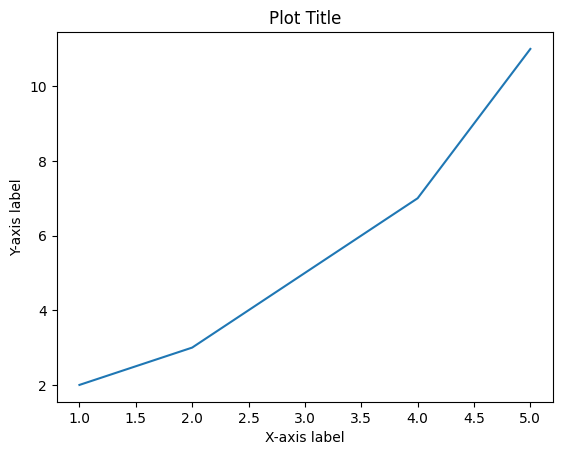

In [1]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]

# Plot
plt.plot(x, y)
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Plot Title')

# Save the plot as an image file
plt.savefig('plot.png')
